In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
%matplotlib inline

In [2]:
yahoo_db = '/home/ian/Data/yahoo.db'
tmx_db = '/home/ian/Data/tmx.db'
advfn_db = '/home/ian/Data/advfn.db'

yahoo_database = sqlite3.connect(yahoo_db)
tmx_database = sqlite3.connect(tmx_db)
advfn_database = sqlite3.connect(advfn_db)


In [3]:
tmx_sql = '''SELECT date, eps FROM tmx_earnings WHERE symbol = "BNS"'''
df_tmx = pd.read_sql_query(tmx_sql, tmx_database)
df_tmx.columns = ['date', 'eps']
df_tmx['date_parsed'] = df_tmx['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_tmx.drop(columns = 'date', inplace = True)

aav_sql = '''SELECT Date, Close FROM aav_prices WHERE symbol = "BNS" AND close != "null"'''
df_aav = pd.read_sql_query(aav_sql, yahoo_database)
df_aav.columns = ['date', 'close']
df_aav['date_parsed'] = df_aav['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_aav.drop(columns = 'date', inplace = True)

yahoo_prices_sql = '''SELECT Date, Close FROM tsx_prices WHERE symbol = "BNS" AND close != "null"'''
df_y_price = pd.read_sql_query(yahoo_prices_sql, yahoo_database)
df_y_price.columns = ['date', 'close']
df_y_price['date_parsed'] = df_y_price['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_y_price.drop(columns = 'date', inplace = True)

divs_sql = '''SELECT Date, Dividends FROM divs WHERE symbol = "BNS"'''
df_divs = pd.read_sql_query(divs_sql, yahoo_database) 
df_divs.columns = ['date', 'div']
df_divs['date_parsed'] = df_divs['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_divs.drop(columns = 'date', inplace = True)

split_sql = '''SELECT date, total_adjustment FROM splits WHERE symbol = "BNS"'''
df_split = pd.read_sql_query(split_sql, yahoo_database) 
df_split.columns = ['date', 'split_adj']
df_split['date_parsed'] = df_split['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_split.drop(columns = 'date', inplace = True)


In [4]:
df_price = pd.concat([df_y_price, df_aav])
print('Before: ' + str(df_price.shape[0]))
df_price.drop_duplicates(subset='date_parsed', inplace = True)
print('After: ' + str(df_price.shape[0]))

Before: 6224
After: 6125


In [5]:
df = df_price.join(df_tmx.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [6]:
df = df.join(df_divs.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [7]:
df.fillna(method='ffill', inplace = True)



In [8]:
df = df.join(df_split.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [9]:
df.set_index(df['date_parsed'], inplace= True)

In [10]:
#split adjustment for current date is 1.0 -- backfill missing values

df.iloc[-1, df.columns.get_loc('split_adj')] = 1.0
df['split_adj'].fillna(method='bfill', inplace = True)
df.tail(5)


,close,date_parsed,eps,div,split_adj
date_parsed,,,,,
2019-05-21,71.79,2019-05-21,1.75,0.87,1.0
2019-05-22,71.28,2019-05-22,1.75,0.87,1.0
2019-05-23,70.50,2019-05-23,1.75,0.87,1.0
2019-05-24,70.60,2019-05-24,1.75,0.87,1.0
2019-05-28,70.60,2019-05-28,0.00,0.87,1.0


In [11]:
#this is for current quarter only - go back and fill the TTM on df_earnings and df_divs
df['pe'] = 0.0
df['dy'] = 0.0

In [12]:
def process_row(row):
    if (row['close'] != row['close']) | (row['close'] == 'null'):
        df.at[row['date_parsed'], 'pe'] = np.NaN
        df.at[row['date_parsed'], 'dy'] = np.NaN
        return
    if row['eps'] == row['eps']:
        if row['eps'] == 0:
            df.at[row['date_parsed'], 'pe'] = np.NaN
        else:
            df.at[row['date_parsed'], 'pe'] = float(row['close']) / (4*row['eps'])
    
    if row['eps'] == row['eps']:
        if row['close'] == 0:
            df.at[row['date_parsed'], 'dy'] = np.NaN
        else:
            df.at[row['date_parsed'], 'dy'] = 4* row['div'] / (float(row['close']) * row['split_adj'])
        
    
    

In [13]:
df['close'].fillna(method = 'bfill', inplace = True)

In [14]:
df.apply(process_row, axis = 1)


date_parsed
1994-11-30    None
1995-01-12    None
1995-01-13    None
1995-01-16    None
1995-01-17    None
1995-01-18    None
1995-01-19    None
1995-01-20    None
1995-01-23    None
1995-01-24    None
1995-01-25    None
1995-01-26    None
1995-01-27    None
1995-01-30    None
1995-01-31    None
1995-02-01    None
1995-02-02    None
1995-02-03    None
1995-02-06    None
1995-02-07    None
1995-02-08    None
1995-02-09    None
1995-02-10    None
1995-02-13    None
1995-02-14    None
1995-02-15    None
1995-02-16    None
1995-02-17    None
1995-02-20    None
1995-02-21    None
              ... 
2019-04-12    None
2019-04-15    None
2019-04-16    None
2019-04-17    None
2019-04-18    None
2019-04-22    None
2019-04-23    None
2019-04-24    None
2019-04-25    None
2019-04-26    None
2019-04-29    None
2019-04-30    None
2019-05-01    None
2019-05-02    None
2019-05-03    None
2019-05-06    None
2019-05-07    None
2019-05-08    None
2019-05-09    None
2019-05-10    None
2019-05-13    None


In [15]:
kern_200 = [0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000015,0.000017,0.000021,0.000024,0.000029,0.000034,0.00004,0.000047,0.000054,0.000063,0.000074,0.000086,0.000099,0.000115,0.000133,0.000153,0.000176,0.000202,0.000231,0.000264,0.000301,0.000342,0.000388,0.00044,0.000498,0.000562,0.000632,0.000711,0.000797,0.000892,0.000996,0.00111,0.001235,0.001371,0.001519,0.001679,0.001852,0.002038,0.002239,0.002455,0.002686,0.002932,0.003194,0.003473,0.003769,0.00408,0.004409,0.004754,0.005116,0.005494,0.005888,0.006297,0.00672,0.007157,0.007607,0.008068,0.00854,0.00902,0.009508,0.010002,0.010499,0.010999,0.011498,0.011996,0.012489,0.012975,0.013453,0.013919,0.014372,0.014809,0.015228,0.015626,0.016002,0.016353,0.016677,0.016972,0.017237,0.01747,0.01767,0.017835,0.017964,0.018058,0.018114,0.018132,0.018114,0.018058,0.017964,0.017835,0.01767,0.01747,0.017237,0.016972,0.016677,0.016353,0.016002,0.015626,0.015228,0.014809,0.014372,0.013919,0.013453,0.012975,0.012489,0.011996,0.011498,0.010999,0.010499,0.010002,0.009508,0.00902,0.00854,0.008068,0.007607,0.007157,0.00672,0.006297,0.005888,0.005494,0.005116,0.004754,0.004409,0.00408,0.003769,0.003473,0.003194,0.002932,0.002686,0.002455,0.002239,0.002038,0.001852,0.001679,0.001519,0.001371,0.001235,0.00111,0.000996,0.000892,0.000797,0.000711,0.000632,0.000562,0.000498,0.00044,0.000388,0.000342,0.000301,0.000264,0.000231,0.000202,0.000176,0.000153,0.000133,0.000115,0.000099,0.000086,0.000074,0.000063,0.000054,0.000047,0.00004,0.000034,0.000029,0.000024,0.000021,0.000017,0.000015,0.000012,0.00001,0.000009,0.000007,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001]
kern_50 =  [0,0.000001,0.000002,0.000005,0.000012,0.000027,0.00006,0.000125,0.000251,0.000484,0.000898,0.001601,0.002743,0.004514,0.00714,0.010852,0.015849,0.022242,0.029993,0.038866,0.048394,0.057904,0.066574,0.073551,0.078084,0.079656,0.078084,0.073551,0.066574,0.057904,0.048394,0.038866,0.029993,0.022242,0.015849,0.010852,0.00714,0.004514,0.002743,0.001601,0.000898,0.000484,0.000251,0.000125,0.00006,0.000027,0.000012,0.000005,0.000002,0.000001,0]

def custom_kernel(func, kern):
    '''
    Convolution of a function by a kernel.
    Kernel must be odd in length
    Function must be longer than kernel    
    '''
    if len(func) < len(kern):
        return func
    else:
        #midpoint of the kernel
        mid_kern = int((len(kern) + 1)/2)
        
    conv_func = np.zeros(len(func))
    
    for index, value in enumerate(func):
        
        ##TODO: this case is backwards I think
        if index < mid_kern:
            #go from kern[mid_kern] to end for zero
            dist_from_start = index -1
            kern_start = mid_kern - dist_from_start         
           
            sum = 0.0
            area = 0.0
            for i in range(kern_start, len(kern)):                
                sum += kern[i] * func[index + i - mid_kern]
                #need to correct for the area under the partial kernel being < 1
                area += kern[i]
            conv_func[index] = sum / area
            
        elif index > len(func) - mid_kern:         
            #go from zero to mid_kern + (distance to end of func)
            dist_to_end = len(func) - index + 1
            sum = 0.0
            area = 0.0
            for i in range(0, (mid_kern + dist_to_end -1)):
                sum += kern[i] * func[index + i - mid_kern]
                area += kern[i]
            conv_func[index] = sum / area   
            
        else:
            #sum of kernel * function over window of kernel length centered on func[index]
            sum = 0.0
            for kern_ind, kern_val in enumerate(kern):
                sum += kern_val * func[index + kern_ind - mid_kern]
            conv_func[index] = sum
        
    return conv_func


In [16]:
df['avg_50'] = custom_kernel(df['close'], kern_50)
df['avg_200'] = custom_kernel(df['close'], kern_200)

In [17]:
today = datetime.datetime.today()
last_close = df.tail(1)['avg_200'][0]

#print('Elapsed: ' + str((today - df.head(1)['date_parsed'][0]).days / 365.25 ) + ' years')


def return_to_date(row):
    elapsed_years = (today - row['date_parsed']).days / 365.25
    if elapsed_years == 0:
        return 1
    gain = last_close / row['close']
    ann_gain = gain ** (1/elapsed_years)
    return 100 * (ann_gain - 1.0) 
    


In [18]:
df['cap_gain'] = df.apply(return_to_date, axis = 1) 
df['tot_gain'] = df['cap_gain'] + (df['dy'] * 100)

In [19]:
df

,close,date_parsed,eps,div,split_adj,pe,dy,avg_50,avg_200,cap_gain,tot_gain
date_parsed,,,,,,,,,,,
1994-11-30,6.1575,1994-11-30,0.2025,NaN,4.0,7.601852,NaN,6.266227,6.501470,10.572181,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,4.0,7.601852,NaN,6.268372,6.507232,10.625895,NaN
1995-01-13,6.2500,1995-01-13,0.2025,NaN,4.0,7.716049,NaN,6.270429,6.513081,10.559453,NaN
1995-01-16,6.3750,1995-01-16,0.2025,NaN,4.0,7.870370,NaN,6.272517,6.519011,10.473320,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,4.0,7.756173,NaN,6.274826,6.525022,10.540896,NaN
1995-01-18,6.3450,1995-01-18,0.2025,NaN,4.0,7.833333,NaN,6.277632,6.531112,10.497202,NaN
1995-01-19,6.3125,1995-01-19,0.2025,NaN,4.0,7.793210,NaN,6.281303,6.537275,10.521756,NaN
1995-01-20,6.1875,1995-01-20,0.2025,NaN,4.0,7.638889,NaN,6.286300,6.543509,10.613858,NaN
1995-01-23,6.1575,1995-01-23,0.2025,NaN,4.0,7.601852,NaN,6.293164,6.549810,10.639724,NaN


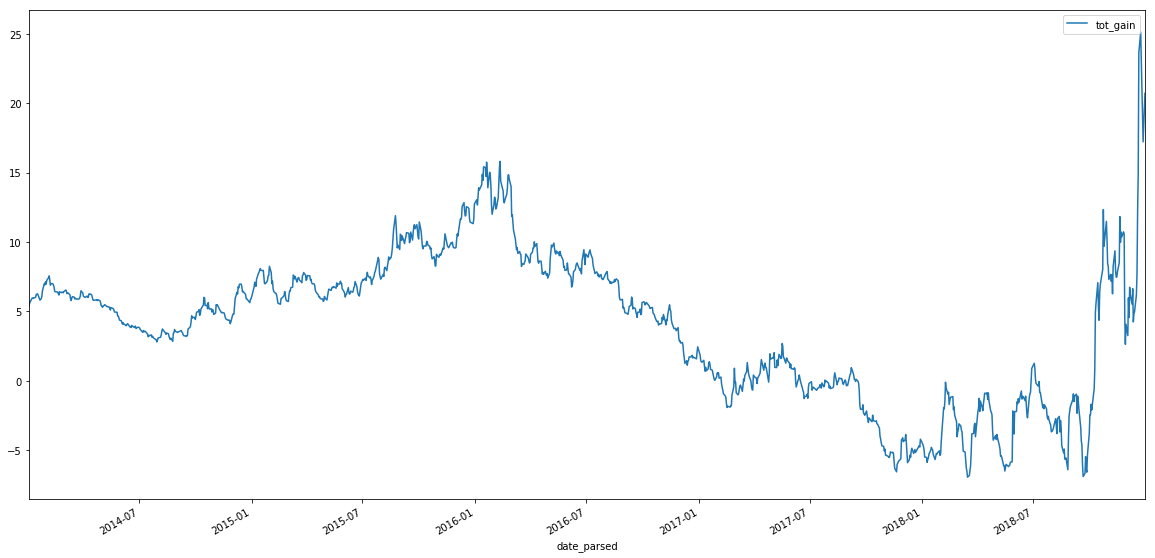

In [20]:

df['2014-01-01' : '2019-01-01'].plot(x = 'date_parsed', y ='tot_gain', figsize=(20,10))


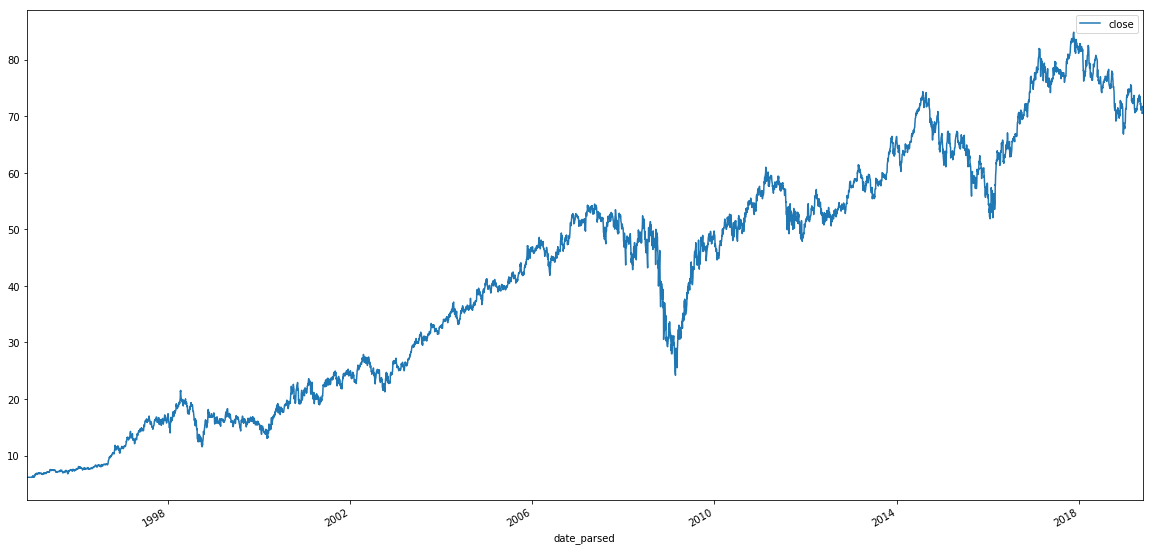

In [21]:
df.plot(x = 'date_parsed', y ='close', figsize=(20,10))

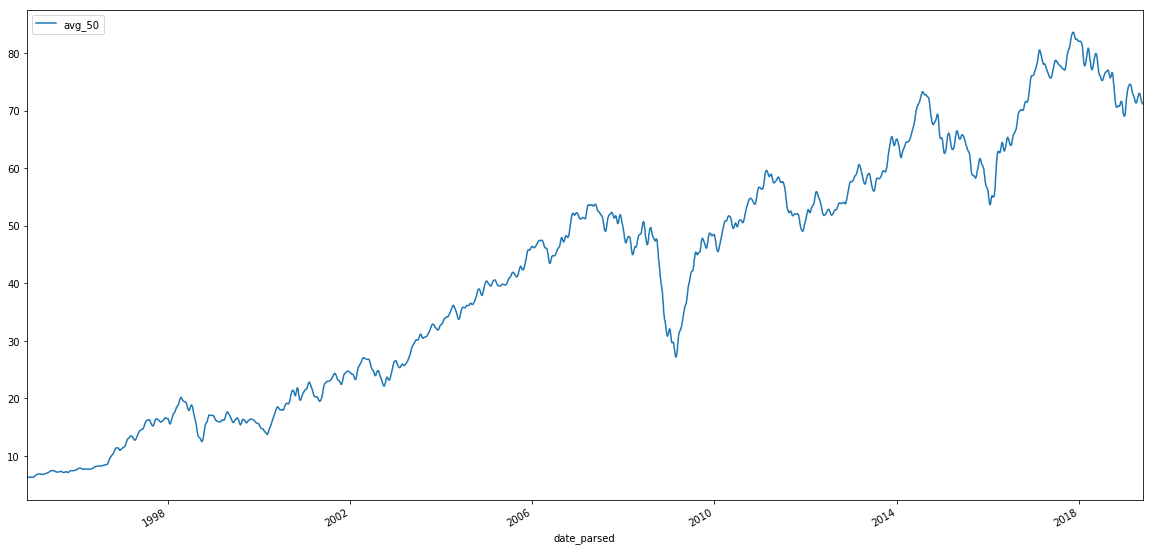

In [22]:
df.plot(x = 'date_parsed', y ='avg_50', figsize=(20,10))

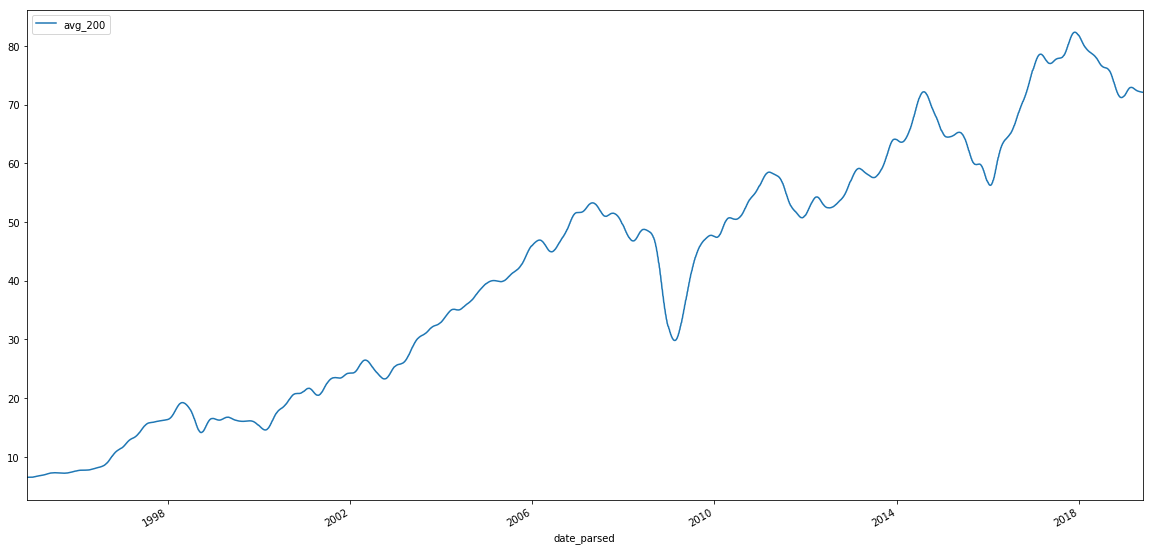

In [23]:
df.plot(x = 'date_parsed', y ='avg_200', figsize=(20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f986e182a90>]],
      dtype=object)

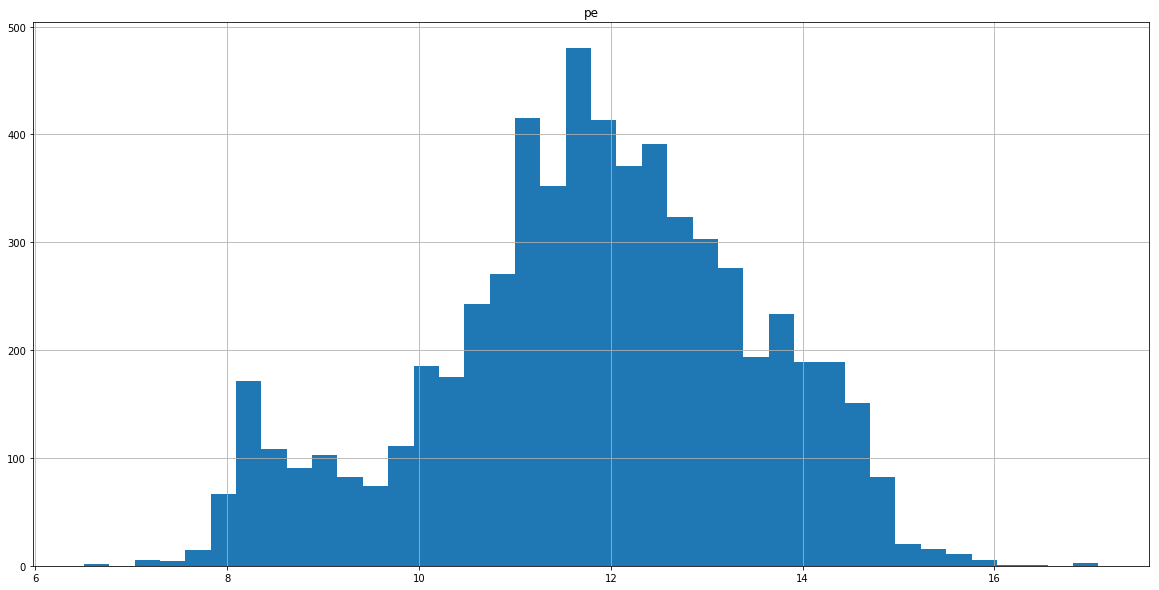

In [24]:
df.hist(['pe'], bins=40, figsize=(20,10))


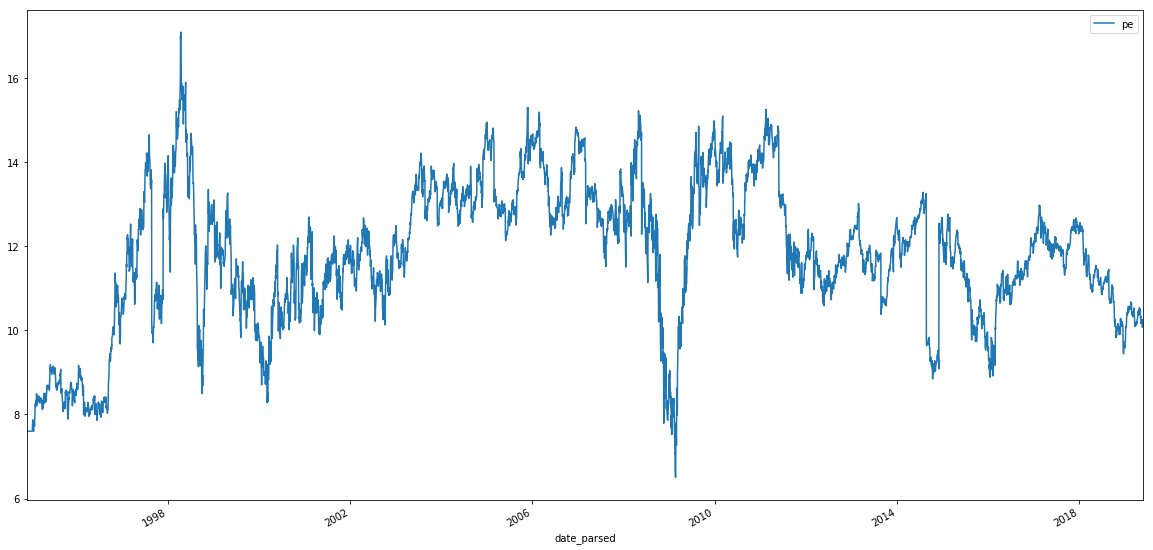

In [25]:
df.plot(x = 'date_parsed', y ='pe', figsize=(20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f986dfee240>]],
      dtype=object)

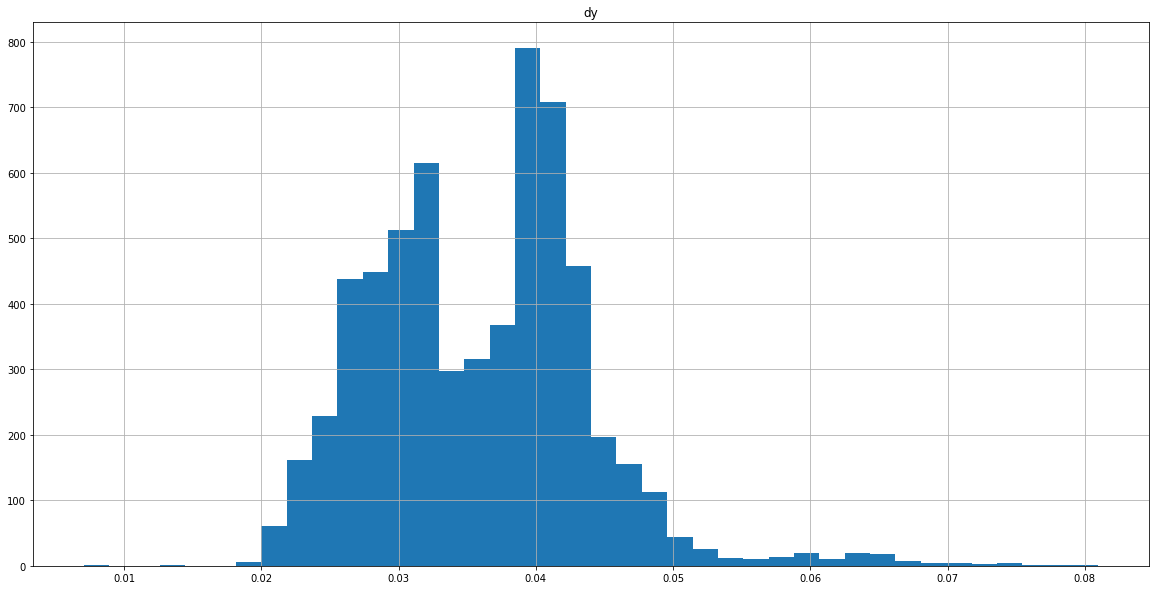

In [26]:
df.hist(['dy'], bins=40, figsize=(20,10))

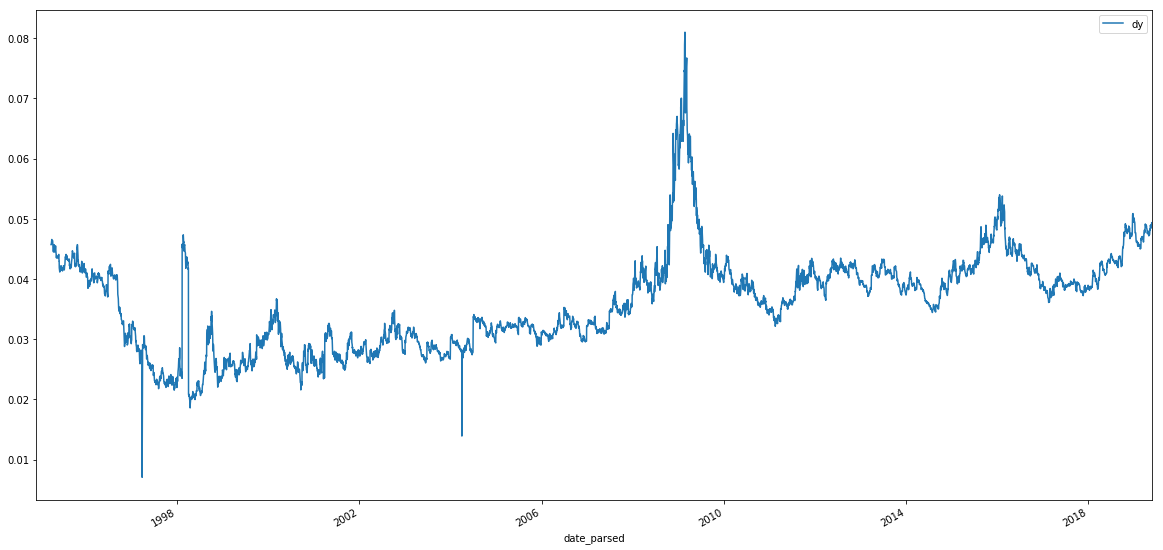

In [27]:
df.plot(x = 'date_parsed', y ='dy', figsize=(20,10))

In [28]:
df['dy'].mean()

0.03599270684109839

In [34]:
df['pe'].mean()
df['pe'].std()

1.684465859620857

In [30]:
'''
TODO:
 - Use TTM for p-e and yield where possible
 - 68/32, 95/5 for pe and dy
 - 68/32, 95/5 (sigma, 2sigma) pe and dy bands, and time series, for each quarter
 - correlate ror to pe
 - correlate ror to dy
 - distribution of ror vs pe +- 5%
 - distribution of ror vs dy +- 5%
 - measure R^2 for ror to pe, ranks TSX composite
 
'''


'\nTODO:\n - Use TTM for p-e and yield where possible\n - 68/32, 95/5 for pe and dy\n - 68/32, 95/5 (sigma, 2sigma) pe and dy bands, and time series, for each quarter\n - correlate ror to pe\n - correlate ror to dy\n - distribution of ror vs pe +- 5%\n - distribution of ror vs dy +- 5%\n - measure R^2 for ror to pe, ranks TSX composite\n \n'

10.51868966161936

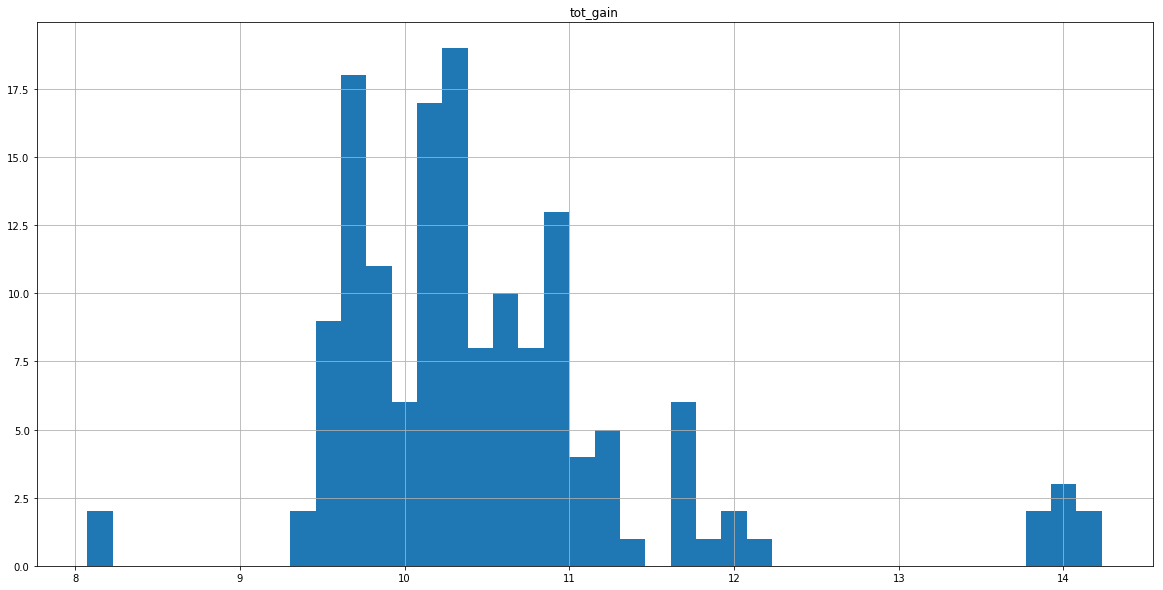

In [31]:
#10.45-10.15
df[(df['pe'] < 10.45) & (df['pe'] > 10.15) & (df['date_parsed'] < '2017-06-06')].hist(['tot_gain'], bins=40, figsize=(20,10))
df[(df['pe'] < 10.45) & (df['pe'] > 10.15) & (df['date_parsed'] < '2017-06-06')]['tot_gain'].mean()

11.836878611112265

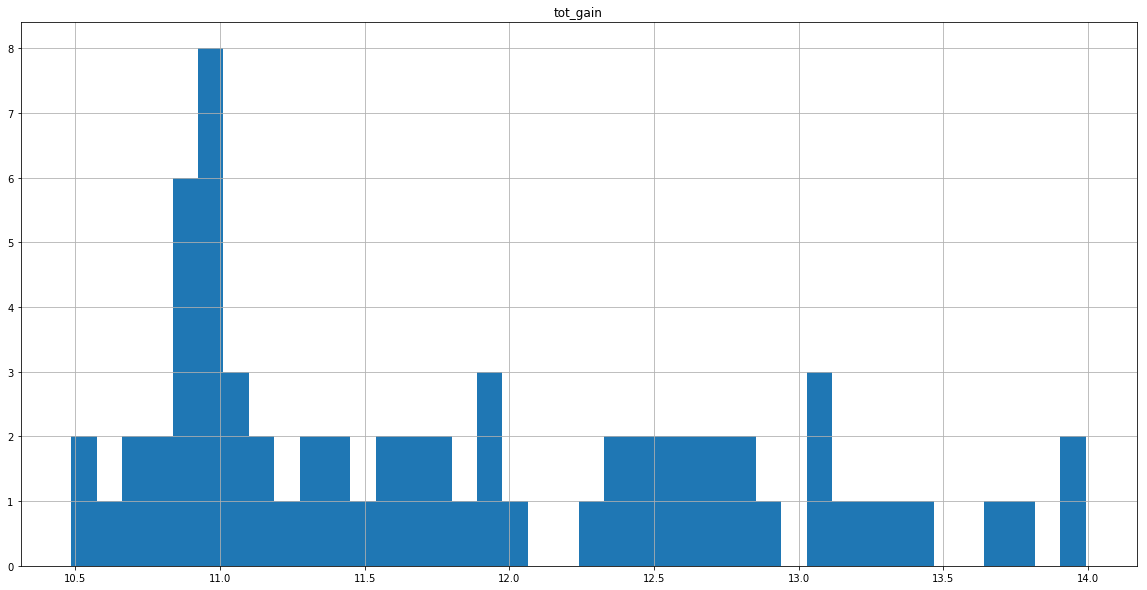

In [32]:
df[(df['dy'] < 0.0514) & (df['dy'] > 0.0484) & (df['date_parsed'] < '2017-06-06')].hist(['tot_gain'], bins=40, figsize=(20,10))
df[(df['dy'] < 0.0514) & (df['dy'] > 0.0484) & (df['date_parsed'] < '2017-06-06')]['tot_gain'].mean()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f986a9a6cf8>]],
      dtype=object)

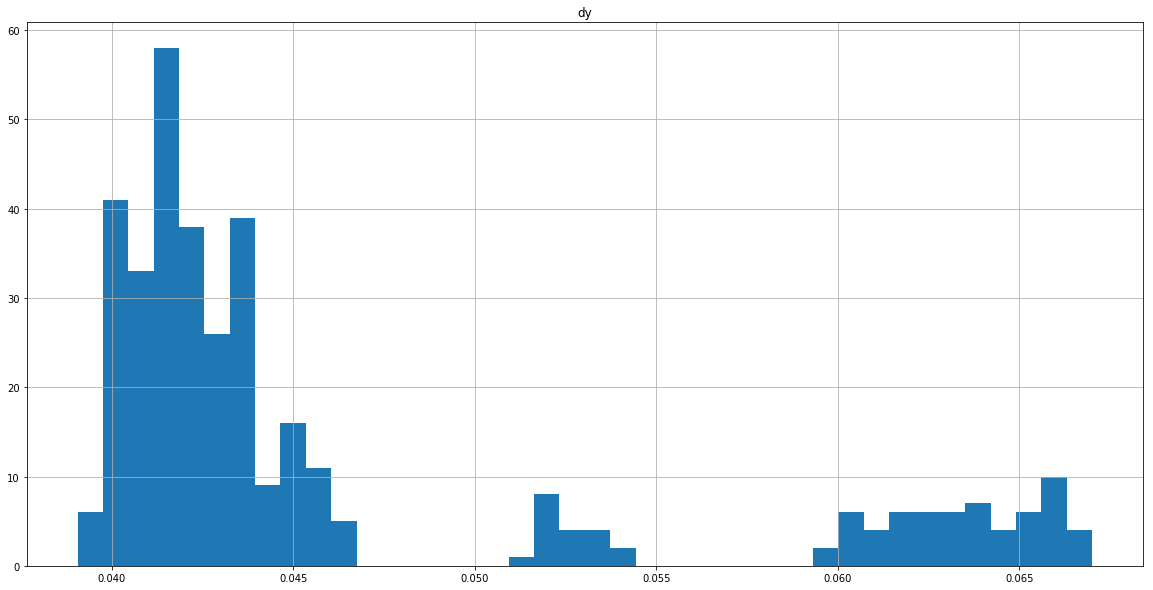

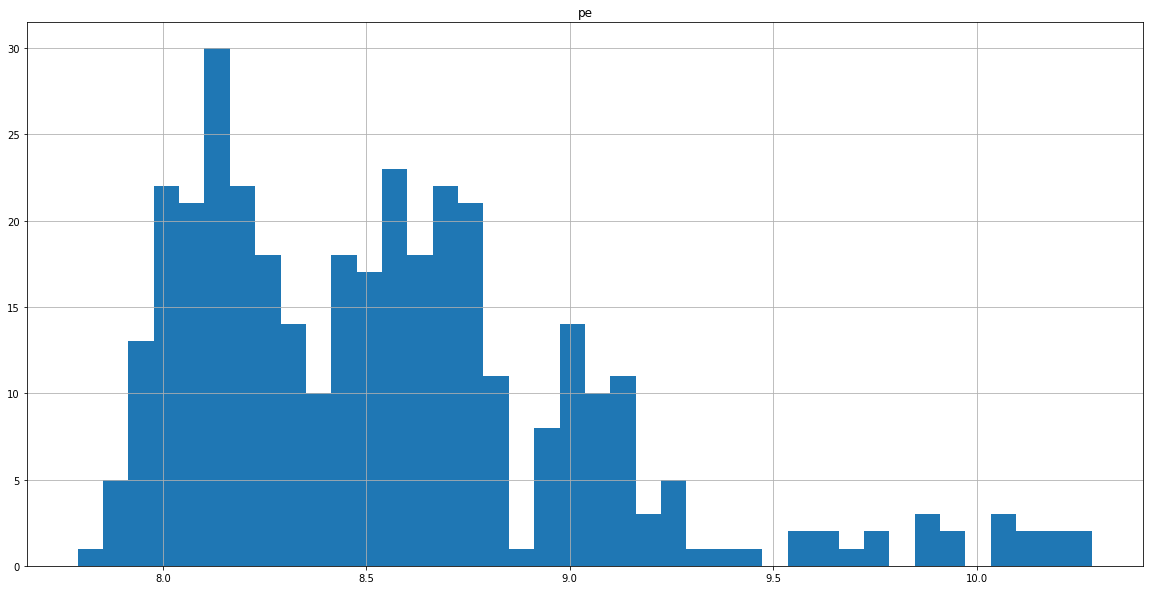

In [33]:
df[(df['tot_gain'] < 16) & (df['tot_gain'] > 14) & (df['date_parsed'] < '2018-06-06')].hist(['dy'], bins=40, figsize=(20,10))
df[(df['tot_gain'] < 16) & (df['tot_gain'] > 14) & (df['date_parsed'] < '2018-06-06')].hist(['pe'], bins=40, figsize=(20,10))

In [36]:
df['2017-06-06':]['tot_gain'].mean()
df['2017-06-06':]['tot_gain'].std()

14765.387241313507

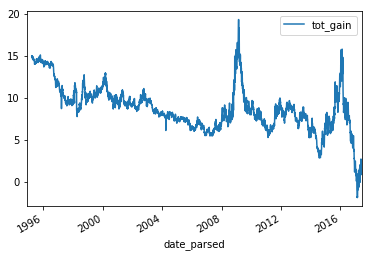

In [39]:
df[:'2017-06-06'].plot(x = 'date_parsed', y = 'tot_gain')